In [5]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

import os
if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

from scripts.plotting_utils import (plot_geog_location, plot_xarray_on_map)

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [21]:
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

In [36]:
# set data and plot dir
if Path('.').absolute().owner() == 'tommylees':
    data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/')
    plot_dir = Path('/Users/tommylees/Downloads')
else:
    data_dir = Path('data')
    plot_dir = Path('.')  # ???

data_path = data_dir / "interim" / "chirps_preprocessed" / "chirps_kenya.nc"

In [7]:
from src.analysis.indices import (
    ZScoreIndex,
    PercentNormalIndex,
    DroughtSeverityIndex,
    ChinaZIndex,
    DecileIndex,
    AnomalyIndex,
    SPI
)

  FutureWarning)



# Fit the indices

In [8]:
from src.analysis.indices.utils import fit_all_indices

ds = fit_all_indices(data_path)

Fitting ZSI for variable: precip
Fitted ZSI and saved at `obj.index`
Fitting PNI for variable: precip
Fitted PNI and saved at `obj.index`
Fitting Hutchinson Drought Severity Index
Fitted Drought Severity Index and saved at `obj.index`
Fitting China Z-Score Index
Fitted China Z-Score Index and saved at `obj.index`
Fitting Decile Index
Fitted DI and saved at `obj.index`
Fitting Rainfall Anomaly Index
Fitted Rainfall Anomaly Index and saved at `obj.index`
Setting the data_start_year automatically: 1981
Setting the inital timeperiod for calibration manually:
            inital year: 1981
Setting the final timeperiod for calibration manually:
            final year: 2019

---------------
 Fitting SPI3 index
 distribution: gamma
 data_start_year: 1981
 calibration_year_initial: 1981
 calibration_year_final: 2019
 periodicity: monthly
 ---------------

Fitted
['z_score_index', 'percent_normal_index', 'drought_severity_index', 'china_z_index', 'decile_index', 'rainfall_anomaly_index', 'spi']
J

In [9]:
# which timesteps are missing?
dr = pd.date_range(start='1981-03-31', end='2019-03-31', freq='M')
missing_timesteps = dr[~np.isin(dr, ds.time)]
print(f"Missing Timesteps: {list(missing_timesteps)}")

Missing Timesteps: []


In [10]:
ds

<xarray.Dataset>
Dimensions:    (lat: 224, lon: 176, time: 457)
Coordinates:
  * time       (time) datetime64[ns] 1981-03-31 1981-04-30 ... 2019-03-31
  * lat        (lat) float32 -5.175003 -5.125 -5.075001 ... 5.924999 5.9749985
  * lon        (lon) float32 33.524994 33.574997 33.625 ... 42.22499 42.274994
Data variables:
    ZSI        (time, lat, lon) float32 0.19730268 0.20589764 ... -1.138107
    PNI        (time, lat, lon) float32 105.755615 105.56473 ... 31.462866
    DSI        (time, lat, lon) float64 1.474 1.053 1.053 ... -4.0 -4.0 -4.0
    CZI        (time, lat, lon) float32 0.32338613 0.30480868 ... -1.422325
    rank_norm  (time, lat, lon) float64 68.42 63.16 63.16 65.79 ... 0.0 0.0 0.0
    quintile   (time, lat, lon) float64 5.0 5.0 5.0 5.0 5.0 ... 4.0 3.0 3.0 3.0
    RAI        (time, lat, lon) float32 29.100836 -636.43274 ... 17.38724
    SPI3       (time, lat, lon) float64 -0.2019 -0.2212 ... -0.7787 -0.8182

# Plot the indices

In [15]:
# spatial
# temporal

# distributions
from scripts.eng_utils import drop_nans_and_flatten
from scripts.plotting_utils import plot_marginal_distribution

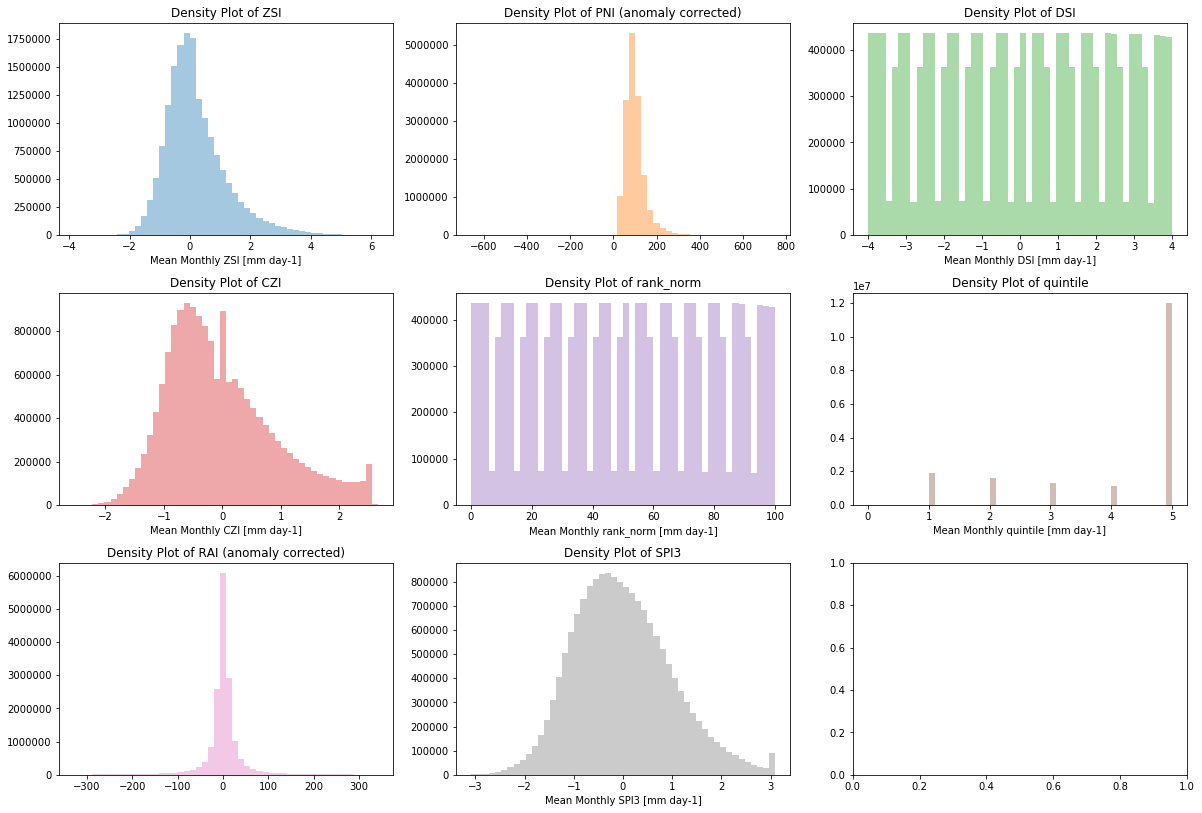

In [93]:
import itertools

scale = 1.4
fig, axs = plt.subplots(3, 3, figsize=(12 * scale, 8 * scale))
ax_ixs = list(itertools.product(range(3), repeat=2))

for ix, index in enumerate(ds.data_vars):
    ax_ix = ax_ixs[ix]
    ax = axs[ax_ix]
    plt.tight_layout()
    
    if (index != 'PNI') and (index != 'RAI'):
        plot_marginal_distribution(ds[index], color=sns.color_palette()[ix], ax=ax, summary=False, **{'kde': False})
    
    if index == 'PNI':
        flat = drop_nans_and_flatten(ds[index])
        flat.sort()
        
        # Remove values more than 10 std away from the mean
        flat = flat[~(flat < flat.mean() - (flat.std() * 10))]
        flat = flat[~(flat > flat.mean() + (flat.std() * 10))]
        
        sns.distplot(flat, color=sns.color_palette()[ix], ax=ax, **{'kde': False})
        ax.set_title('Density Plot of PNI (anomaly corrected)')
        
    if index == 'RAI':
        flat = drop_nans_and_flatten(ds[index])
        flat.sort()
        
        # Remove outside of 1-99 percentiles
        flat = flat[~(flat < np.percentile(flat, q=1))]
        flat = flat[~(flat > np.percentile(flat, q=99))]

        ax.set_title('Density Plot of RAI (anomaly corrected)')
        sns.distplot(flat, color=sns.color_palette()[ix], ax=ax, **{'kde': False})

fig.savefig(plot_dir / 'indexes_marginal_distribution.png')

In [90]:
ix = [ix for ix, var_ in enumerate(ds.data_vars) if var_ == 'RAI'][0]
index = 'RAI'

flat = drop_nans_and_flatten(ds[index])
flat.sort()
print(len(flat), flat.min(), flat.max())

# Remove outside of 1-99 percentiles
flat = flat[~(flat < np.percentile(flat, q=1))]
flat = flat[~(flat > np.percentile(flat, q=99))]
print(len(flat), flat.min(), flat.max())

16606009 -8938910.0 4887574.0
16275548 -328.89804 342.33176


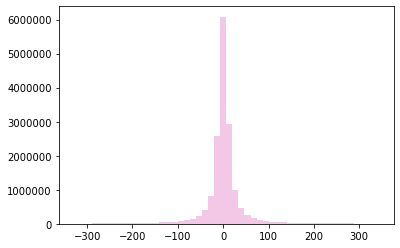

In [92]:
fig, ax = plt.subplots()

    
sns.distplot(flat, color=sns.color_palette()[ix], ax=ax, **{'kde': False})

<xarray.DataArray 'PNI' ()>
array(440.976443)
Coordinates:
    quantile  float64 0.999

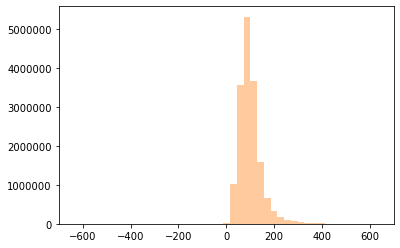

In [62]:
ds.where(ds.PNI == ds.PNI.max(), drop=True)

<xarray.Dataset>
Dimensions:    (lat: 1, lon: 1, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2000-07-31
  * lat        (lat) float64 0.725
  * lon        (lon) float64 38.93
Data variables:
    ZSI        (time, lat, lon) float32 2.0573823
    PNI        (time, lat, lon) float32 58156.523
    DSI        (time, lat, lon) float64 4.0
    CZI        (time, lat, lon) float32 1.7384312
    rank_norm  (time, lat, lon) float64 100.0
    quintile   (time, lat, lon) float64 1.0
    RAI        (time, lat, lon) float32 -6.4857473
    SPI3       (time, lat, lon) float64 0.3393

# Explore consecutive anomalies with the EventDetector

In [64]:
indices_dir = Path(data_dir / 'data/analysis/indices')

if not indices_dir.exists():
    indices_dir.mkdir(exist_ok=True, parents=True)

index_path = (indices_dir / 'all_indices_kenya.nc')
if not index_path.exists():
    ds.to_netcdf(index_path)
else:
    ds = xr.open_dataset(index_path)

In [79]:
from src.analysis import EventDetector

e = EventDetector(indices_dir / 'all_indices_kenya.nc')
e.detect(
    variable='SPI3', time_period='month', hilo='low', method='abs', value=-1
)

all_indices_kenya.nc read!
Detecting SPI3 exceedences (low) of threshold:         abs. The threshold is unique for each month
Calculated climatology (mean for each month) - `clim`
Calculated threshold - `thresh`
** exceedences calculated **


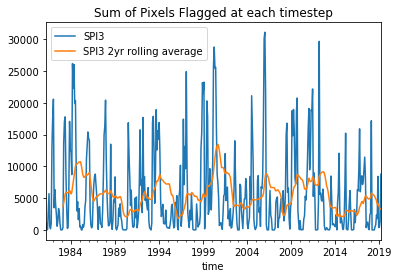

In [112]:
df = e.exceedences.sum(dim=['lat','lon']).to_dataframe()
fig, ax = plt.subplots()
df.plot(ax=ax)
df.rolling(window=24).mean().rename(columns={'SPI3': 'SPI3 2yr rolling average'}).plot(ax=ax)
ax.set_title('Sum of Pixels Flagged at each timestep')
plt.legend()

# Consecutive exceedences

In [116]:
runs = e.calculate_runs()

<xarray.DataArray 'SPI3' ()>
array(16.)

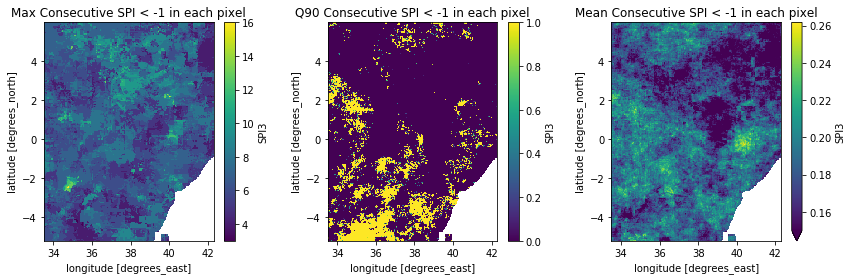

In [145]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

runs.max(dim=['time']).plot(ax=axs[0])
axs[0].set_title('Max Consecutive SPI < -1 in each pixel')

runs.quantile(dim=['time'], q=0.9).plot(ax=axs[1])
axs[1].set_title('Q90 Consecutive SPI < -1 in each pixel')

runs.mean(dim=['time']).plot(ax=axs[2], vmin=0.15)
axs[2].set_title('Mean Consecutive SPI < -1 in each pixel')

plt.tight_layout()

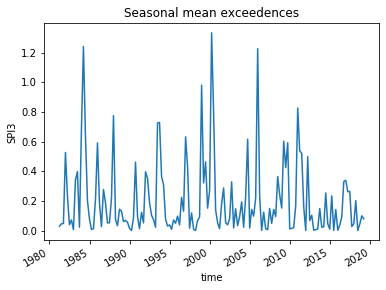

In [134]:
fig, ax = plt.subplots()
runs.resample(time='Q-DEC').mean().plot(ax=ax)
ax.set_title('Seasonal mean exceedences');